In [1]:
import numpy as np
from numpy import sin, sqrt, abs
from numpy.random import randint, rand, choice

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
def rastrigin(x):
    # -5.12 <= x_i <= 5.12 for i=1,..,n
    # global minimum at f(0,..,0)=0
    if isinstance(x, list):
        x = np.array(x)
    A, n = 10, len(x)
    return A * n + np.sum(x ** 2 - A * np.cos(2 * np.pi * x), axis=0)


def booth(arg):
    # -10 <= x,y <= 10 
    # global minimum at f(1,3)=0
    x, y = arg
    return (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2


def eggholder(arg):
    # -512 <= x,y <= 512
    # global minimum at f(512,404.2319)=-959.6407
    x, y = arg
    return -(y + 47) * sin(sqrt(abs(x / 2 + y + 47))) - x * sin(sqrt(abs(x-y-47)))


functions_data = {
    'rastrigin': {'func': rastrigin, 'bounds': [[-5.12, 5.12], [-5.12, 5.12]], "best": ([0.0, 0.0], 0.0)},
    'booth'    : {'func': booth,     'bounds': [[-10, 10], [-10, 10]], "best": ([1, 3], 0.0)},
    'eggholder': {'func': eggholder, 'bounds': [[-512.0, 512.0], [-512.0, 512.0]], "best": ([512, 404.2319], -959.6407)},
}

# Графіки цільових функцій

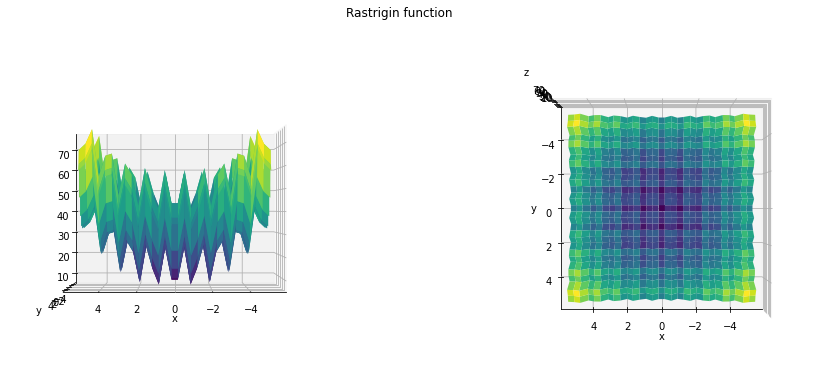

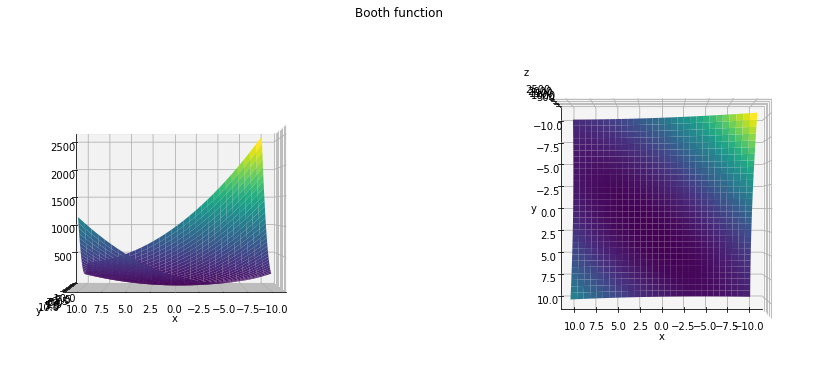

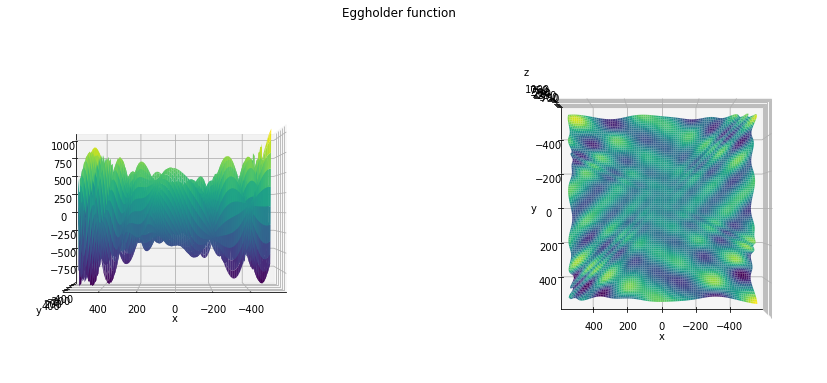

In [3]:
def plot_function(x, y, func, func_name):
    X, Y = np.meshgrid(x, y)
    Z = func(np.array([X, Y]))

    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    fig.suptitle(func_name)
    
    ax1.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax2.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax1.view_init(0, 90); ax2.view_init(90, 90)
    ax1.set_xlabel('x'); ax2.set_xlabel('x')
    ax1.set_ylabel('y'); ax2.set_ylabel('y')
    ax2.set_zlabel('z'); ax2.set_zlabel('z')
    
    
x = np.linspace(-5.12, 5.12, 30)
y = np.linspace(-5.12, 5.12, 30)
plot_function(x, y, rastrigin, "Rastrigin function")

x = np.linspace(-10, 10, 30)
y = np.linspace(-10, 10, 30)
plot_function(x, y, booth, "Booth function")

x = np.linspace(-512, 512, 100)
y = np.linspace(-512, 512, 100)
plot_function(x, y, eggholder, "Eggholder function")

# Genetic Algorithm

<img src="images/GA_algorithm.png" width=300 height=300 />

The following implementation is mostly based on the 8-th chapter in "The Fundamentals of Computational Intelligence: System Approach" by M. Zgurovsky and Y. Zaychenko

In [4]:
def gray_encode(value):
    if isinstance(value, str):
        value = int(value, 2)
    return bin(value ^ (value >> 1))[2:]


def gray_decode(value):
    if isinstance(value, str):
        mask = int(value, 2)
        value = mask
    if isinstance(value, int):
        mask = value
    while mask:
        mask >>= 1
        value ^= mask
    return bin(value)[2:]
    

def initialize_parameters(bounds, eps):
    m = max([right - left for left, right in bounds])
    string_length = int(np.log2(m / eps + 1)) + 1
    return string_length

    
def decode(bitstring, bounds, int_length):
    k = 2 ** int_length + 1
    values = [
        int(gray_decode(bitstring[int_length*n:int_length*(n+1)]), 2) 
        for n in range(len(bounds))
    ]
    res = [left + (right - left) / k * v for (left, right), v in zip(bounds, values)]
    return res


# str_length = initialize_parameters([[-10, 10], [-5, 5]], 0.1)
# decode("01100011", [[-10, 10]], 8)

# bounds = [[-10, 10], [-10, 10]]
# k = initialize_parameters(bounds, 0.02)
# b_str = '01000010010101100111'
# decode(b_str, bounds, 0.02, k)

# b_str = '11000010010101100111'
# decode(b_str, bounds, 0.02, k)

 ### Parents selection

A selection can be performed in various ways:
We get to create pairs from a given set of popuulation to produce offsprings:
 - in a sorted list from best to worst choose pairs of parents
 - Tournament selection: each parent is the fittest chromosome randomly selected from a small subset (2-3 chromosomes), 


In [5]:
def sorted_samples_selection(pop, n_pairs):
    return [[pop[(2*i) % len(pop)], pop[(2*i+1) % len(pop)]] for i in range(n_pairs)]


def tournament_selection(pop, scores, n_pairs):
    pairs = []
    for i in range(n_pairs):
        f = sorted(choice(range(len(pop)), 3, False), key=lambda x: scores[x])[0]
        while True:
            m = sorted(choice(range(len(pop)), 3, False), key=lambda x: scores[x])[0]
            if f != m: 
                pairs.append([pop[f], pop[m]])
                break
    return pairs


def selection(pop, scores, n_pairs, mode="tournament"):
    # it is assumed that pop is already sorted
    if mode == "tournament":
        return tournament_selection(pop, scores, n_pairs)
    elif mode == "sorted samples":
        return sorted_samples_selection(pop, n_pairs)
    raise Exception(f"Mode '{mode}' is not supported for selection")


### Crossover 
Crossover operators can be divided into three main categories based on the arity:
- asexual, where an offspring is generated from one parent.
- sexual, where two parents are used to produce one or two offspring.
- multi-recombination, where more than two parents are used to produce one or more offspring.

Each pair (or group) of parents have a probability $p_c$ of producing offspring.
Usually, a high crossover probability is used.

Several crossover operators have been developed to compute the mask:
- One-point crossover
- N-point crossover
- Uniform crossover (for each bit it is randomly decided which parent it is taken from)

Here the most common form of crossover is implemented: 2 parents produce 2 offsprings with 3 variations described above

In [6]:
def single_point_crossover(p1, p2, idx):
    return p1[:idx] + p2[idx:], p2[:idx] + p1[idx:]
    

def multi_point_crossover(p1, p2, indexes):
    c1, c2 = p1, p2
    for idx in indexes:
        c1, c2 = single_point_crossover(c1, c2, idx)
    return c1, c2
    

def uniform_crossover(p1, p2, mask):
    c1, c2 = "", ""
    for i in range(len(mask)):
        if mask[i]:
            c1 += p1[i]; c2 += p2[i]
        else:
            c1 += p2[i]; c2 += p1[i]
    return c1, c2


def crossover(p1, p2, mode="single", k=1):
    """ a crossover operator with 3 possible modes: "single", "multi", "uniform"
    for a "multi"-mode parameter k can be specified
    """
    if mode == "single":
        assert k == 1
        return single_point_crossover(p1, p2, randint(1, len(p1)))
    elif mode == "multi":
        assert k < len(p1)
        range_list = list(range(1, len(p1)))
        np.random.shuffle(range_list)
        return multi_point_crossover(p1, p2, range_list[:k])
    elif mode == "uniform":
        assert k == 1
        mask = randint(0, 2, len(p1))
        return uniform_crossover(p1, p2, mask)
    raise Exception(f"Mode '{mode}' is not supported")


### Mutation

The aim of mutation is to introduce new genetic material into an existing individual;
that is, to add diversity to the genetic characteristics of the population. Mutation is
used in support of crossover to ensure that the full range of allele is accessible for
each gene.

Some of the types of mutation:
- Uniform (random) mutation, where bit positions are chosen randomly and the corresponding bit values are negated 
- Inorder mutation, where two mutation points are randomly selected and only the bits between these mutation points undergo random mutation. 

Here the first option is implemented

In [7]:
def mutation(bitstring, r_mut):
    """ Mutation operator
    Here uniform mutation is implemented
    """
    return ''.join([str(1 - int(bit)) if rand() < r_mut else bit for bit in bitstring])

### Repopulate

So here I have chosen two different approaches:

1. The old population is completely replaced by newly produced offsprings (in this case we have to produce **n_population** of them -> n_population / 2 of parents, considering the way mating process works)
2.  At first it is decided what portion of the old population survives ($N_{keep}$, usually 50% of all), obviously, the most fit ones get to live and then we create so many offsprings as we need in order to get **n_population** chromosomes

In [8]:
def ultimate_repopulation(pop, scores, selection_mode, crossover_mode, mut_prob):
    parents = selection(
        pop, scores, len(pop) // 2, mode=selection_mode)
    children = []
    for p1, p2 in parents:
        c1, c2 = crossover(p1, p2, crossover_mode)
        if rand() < mut_prob:
            c1 = mutation(c1, mut_prob)
            c2 = mutation(c2, mut_prob)
        children += [c1, c2]
    return children


def legacy_repopulation(pop, scores, n_keep, selection_mode, crossover_mode, mut_prob):
    n = len(pop)
    parents = selection(
        pop[:int(n_keep * n)], scores, int(n * (1 - n_keep)) // 2, mode=selection_mode)
    children = pop[:int(n_keep * n)]
    for p1, p2 in parents:
        c1, c2 = crossover(p1, p2, crossover_mode)
        if rand() < mut_prob:
            c1 = mutation(c1, mut_prob)
        if rand() < mut_prob:
            c2 = mutation(c2, mut_prob)
        children += [c1, c2]
    return children
        
    
def repopulate(pop, scores, selection_mode, crossover_mode, mut_prob, repopulation_mode="ultimate", n_keep=None):
    if repopulation_mode == "ultimate":
        return ultimate_repopulation(pop, scores, selection_mode, crossover_mode, mut_prob)
    if repopulation_mode == "legacy":
        assert n_keep
        return legacy_repopulation(pop, scores, n_keep, selection_mode, crossover_mode, mut_prob)

In [44]:
def binary_genetic_algorithm(*args, **kwargs):
    cost, bounds = args
    n_iter, eps, n_pop, selection_mode, repopulation_mode, n_keep, crossover_mode, r_mut = kwargs.values()
    
    #initialize population
    n_bits = initialize_parameters(bounds, eps)
    pop = [''.join(map(str, randint(0, 2, n_bits*len(bounds)))) for _ in range(n_pop)]
    best, best_score = 0, cost(decode(pop[0], bounds, n_bits))
    iteration, n_iter_without_update = 0, 0
    # if the best answer isn't updated for 20 iterations in a row, then we can finish execution
    while n_iter_without_update < 100 and iteration < n_iter:
        iteration += 1
        n_iter_without_update += 1
        scores = [cost(decode(p, bounds, n_bits)) for p in pop]
        # choose new best solution
        sorted_pop = sorted(zip(pop, scores), key=lambda x: x[1])
        pop = [p[0] for p in sorted_pop]
        scores = [p[1] for p in sorted_pop]
        if best_score != scores[0]:
            n_iter_without_update = 0
            best, best_score = pop[0], scores[0]
        # select parents
        pop = repopulate(pop, scores, selection_mode, crossover_mode, r_mut, repopulation_mode, n_keep)

    return iteration, decode(best, bounds, n_bits), best_score

## Checks

In [39]:
from termcolor import colored, cprint

color_string = lambda x: colored(x, 'blue', attrs=["bold"])

In [41]:
print("(For each result we run the algorith 10 times and then take the mean value)")
for f_name in ['rastrigin', 'eggholder', 'booth']:
    func, bounds = functions_data[f_name]['func'], functions_data[f_name]['bounds']

    configurations = [
        {"n_iter": 1000, "eps": 0.01, "n_pop": 100, "selection_mode": "tournament", "repopulation_mode": "legacy", "n_keep": 0.5, "crossover_mode": "single", "r_mut": 0.05},
        {"n_iter": 1000, "eps": 0.01, "n_pop": 100, "selection_mode": "tournament", "repopulation_mode": "ultimate", "n_keep": None, "crossover_mode": "single",  "r_mut": 0.05},
    ]
    (best_x, best_y), best_score = functions_data[f_name]['best']
    print(color_string(f"function: {f_name:<10s}  best solution: f({best_x:> .3f}, {best_y:> .3f}) = {functions_data[f_name]['best'][1]}"))
    for conf in configurations:
        sum_iter, sum_best, sum_score = 0, np.array([.0, .0]), .0
        n = 5
        for i in range(n):
            iteration, best, score = binary_genetic_algorithm(func, bounds, **conf)
            sum_iter += iteration
            sum_best += best
            sum_score += score
        best = sum_best / n ; score = sum_score / n; iteration = int(sum_iter / n)
        print(
            f"repopulation mode: {conf['repopulation_mode']:<10s}  f({best[0]:> 6.3f}, {best[1]:> 6.3f}) = {score:> .5f}  "
            f"(stopped after {iteration} iterations)"
        )
    print()

(For each result we run the algorith 10 times and then take the mean value)
function: rastrigin   best solution: f( 0.000,  0.000) = 0.0
repopulation mode: legacy      f( 0.007,  0.011) =  0.14053  (stopped after 50 iterations)
repopulation mode: ultimate    f( 0.199,  0.200) =  0.40228  (stopped after 42 iterations)

function: eggholder   best solution: f( 512.000,  404.232) = -959.6407
repopulation mode: legacy      f(-95.161,  409.487) = -914.75696  (stopped after 106 iterations)
repopulation mode: ultimate    f( 70.900,  470.049) = -885.77623  (stopped after 183 iterations)

function: booth       best solution: f( 1.000,  3.000) = 0.0
repopulation mode: legacy      f( 1.049,  2.925) =  0.09999  (stopped after 60 iterations)
repopulation mode: ultimate    f( 0.985,  3.013) =  0.00177  (stopped after 90 iterations)



In [ ]:
print("(For each result we run the algorith 5 times and then take the mean value)")
for f_name in ['rastrigin', 'eggholder', 'booth']:
    func, bounds = functions_data[f_name]['func'], functions_data[f_name]['bounds']

    configurations = [
        {"n_iter": 1000, "eps": 0.01, "n_pop": 100, "selection_mode": "sorted samples", "repopulation_mode": "legacy", "n_keep": 0.5, "crossover_mode": "single", "r_mut": 0.05},
        {"n_iter": 1000, "eps": 0.01, "n_pop": 100, "selection_mode": "tournament", "repopulation_mode": "legacy", "n_keep": 0.5, "crossover_mode": "single",  "r_mut": 0.05},
    ]
    (best_x, best_y), best_score = functions_data[f_name]['best']
    print(color_string(f"function: {f_name:<10s}  best solution: f({best_x:> .3f}, {best_y:> .3f}) = {functions_data[f_name]['best'][1]}"))
    for conf in configurations:
        sum_iter, sum_best, sum_score = 0, np.array([.0, .0]), .0
        n = 5
        for i in range(n):
            iteration, best, score = binary_genetic_algorithm(func, bounds, **conf)
            sum_iter += iteration
            sum_best += best
            sum_score += score
        best = sum_best / n ; score = sum_score / n; iteration = int(sum_iter / n)
        print(
            f"selection mode: {conf['selection_mode']:<15s}  f({best[0]:> 6.3f}, {best[1]:> 6.3f}) = {score:> .5f}  "
            f"(stopped after {iteration} iterations)"
        )
    print()

(For each result we run the algorith 5 times and then take the mean value)
function: rastrigin   best solution: f( 0.000,  0.000) = 0.0
